# What do people say about the businesses that are opened vs closed?

In [36]:
import pandas as pd
import seaborn as sb
sb.set_theme()
import re
import nltk

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import trigrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [37]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joeylim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/joeylim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joeylim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
reviews = pd.read_parquet("https://ntu-sc1015-yelp.s3.ap-southeast-1.amazonaws.com/yelp_reviews_inner.parquet/part-00000-tid-2558117656403601659-b3029da0-4c99-4b8b-8c7a-cdb7db9371e5-1209-1-c000.snappy.parquet") 
reviews.head()

,user_id,business_id,cool,date,funny,review_id,stars,text,useful,business_address,...,user_compliment_writer,user_cool,user_elite,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since
0,-3-GR6zLPQUQXC02xE5QaA,Kfaq9cuyeXHkzWwL39jUWw,0,2022-01-08,0,5teG7qQ0oxQNRhXTkTV-AA,5.0,"If you leave hungry, it's your own fault. Ther...",0,311 Salem Pl,...,0,5,,0,"vm2DaLbzM9KxVjDU6gmMRQ, H5fheR7XkbgdOhUD2KijTw...",3,Tracey,41,14,2016-01-25 22:20:02
1,-5Qgwxo8lTJQdadtJY879w,9CRWWbw3iOo4-9FMAO6nKw,0,2021-12-31,0,yhJplqlngFVTFk5W_velmQ,5.0,They where able to provide very good sandwiche...,0,1302 Magazine St,...,0,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43
2,-5Qgwxo8lTJQdadtJY879w,SJIQFKTW6uUsOo29w9IHxw,0,2021-12-31,0,Q90M8AHlNxUVL0ii7MAj1w,5.0,Was able to have very tasty po boy alligator a...,0,411 Bourbon St,...,0,0,,0,None,0,Mike,4,1,2020-10-28 01:46:43
3,-6J6EFoigdncrbw586jAQg,gP_oWJykA2RocIs_GurKWQ,0,2021-11-20,0,FkuvWGHoqveIKmG2JjuEXg,5.0,"While shopping in the area, we decided to try ...",0,"2000 Mallory Ln, Ste 615",...,0,0,,0,"7SwgKCa2IYP2tmxxDpuwaw, vwRUqCoINjuBdozwgvVCxA...",0,Paige,1,0,2021-11-20 18:40:41
4,-9q7GFmibqq3E6W0Bw3_jQ,gJSNa1bxwtY0dm1t-dh38w,0,2022-01-13,0,P7zB0L55i7zwFt3vjAa8lw,1.0,Food was horrible. Hot and sour soup had no fl...,0,219 Westshore Plz,...,0,0,,0,"BtUw263un2hRPQ7OvEF-8g, gh7JzS4v_xiTGUOG2kjLkQ...",0,Diana,2,5,2011-01-21 21:14:45


In [39]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99967 entries, 0 to 99966
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  99967 non-null  object 
 1   business_id              99967 non-null  object 
 2   cool                     99967 non-null  int64  
 3   date                     99967 non-null  object 
 4   funny                    99967 non-null  int64  
 5   review_id                99967 non-null  object 
 6   stars                    99967 non-null  float64
 7   text                     99967 non-null  object 
 8   useful                   99967 non-null  int64  
 9   business_address         99967 non-null  object 
 10  business_attributes      95264 non-null  object 
 11  business_categories      99943 non-null  object 
 12  business_city            99967 non-null  object 
 13  business_hours           94880 non-null  object 
 14  business_is_open      

In [40]:
businesses_df = pd.read_json("../businesses.json", lines=True)
businesses_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [41]:
businesses_closed = businesses_df.query("is_open == 0")
businesses_closed.shape

(30648, 14)

In [42]:
businesses_open = businesses_df.query("is_open == 1")
businesses_open.shape

(119698, 14)

In [43]:
businesses_closed.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
20,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,Edmonton,AB,T5J 1B9,53.546045,-113.499169,4.0,40,0,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."


### Get business ids of closed / open businesses

In [44]:
business_id_closed = businesses_closed["business_id"]
business_id_open = businesses_open["business_id"]

### Get reviews of restaurants that are closed / open

In [45]:
reviews_of_closed_businesses = reviews[reviews["business_id"].isin(business_id_closed.values)]
reviews_of_open_businesses = reviews[reviews["business_id"].isin(business_id_open.values)]

In [46]:
reviews_of_closed_businesses.shape

(367, 43)

In [47]:
reviews_of_open_businesses.shape

(99600, 43)

In [48]:
closed_reviews_text = reviews_of_closed_businesses["text"]
closed_reviews_text.head()

320     This is The Gift Box. They have all the awesom...
525     Well, another appoinment to fix our refrigerat...
654     A rather traditional style diner. Nothing fanc...
1013    Sadly I had expected more from this location. ...
1275    When it first opened was my favorite place to ...
Name: text, dtype: object

In [49]:
open_reviews_text = reviews_of_open_businesses["text"]
open_reviews_text.head()

0    If you leave hungry, it's your own fault. Ther...
1    They where able to provide very good sandwiche...
2    Was able to have very tasty po boy alligator a...
3    While shopping in the area, we decided to try ...
4    Food was horrible. Hot and sour soup had no fl...
Name: text, dtype: object

### Get rid of stopwords and punctuation and convert everything to lowercase

In [50]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stop_words])
    
    return review

In [51]:
closed_reviews_text = closed_reviews_text.apply(clean)
closed_reviews_text = closed_reviews_text.to_frame()

open_reviews_text = open_reviews_text.apply(clean)
open_reviews_text = open_reviews_text.to_frame()

In [52]:
closed_reviews_text.head()

,text
320,gift box awesome candies beautiful gift ideas ...
525,well another appoinment fix refrigerator cance...
654,rather traditional style diner nothing fancy m...
1013,sadly expected location made appointment clear...
1275,first opened favorite place eat went got gift ...


In [53]:
open_reviews_text.head()

,text
0,leave hungry fault 8 us left happy leftovers good
1,able provide good sandwiches paninis burgers g...
2,able tasty po boy alligator fish service bar f...
3,shopping area decided try yats something diffe...
4,food horrible hot sour soup flavor egg rolls s...


### Lemmatize the words
We want to group words like "eat" "eaten" and "eating" into their base form so that they count as the same word instead of separate words

In [54]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(lemmatized_tokens)

In [55]:
closed_reviews_text["text"].apply(lemmatize_text)
open_reviews_text["text"].apply(lemmatize_text)

0          leave hungry fault 8 u left happy leftover good
1        able provide good sandwich panini burger group...
2        able tasty po boy alligator fish service bar f...
3        shopping area decided try yats something diffe...
4        food horrible hot sour soup flavor egg roll so...
                               ...                        
99962    sadie colton amazing colton greeted u sat u so...
99963    hub heard constant advertisement kmox radio sa...
99964    love place super close house everyone bartende...
99965    location never opened website say store open 1...
99966    croissant dont french toast hash brown wildwha...
Name: text, Length: 99600, dtype: object

### Term Frequency Analysis
We want to know what people who patronise closed businesses say about the business

In [56]:
def count_freq(text):
    tokens = word_tokenize(text)
    tokens = trigrams(tokens)
    return Counter(tokens)


In [57]:
closed_reviews_text['word_frequency'] = closed_reviews_text['text'].apply(count_freq)
open_reviews_text['word_frequency'] = open_reviews_text['text'].apply(count_freq)

In [58]:
def convert_tuple_to_string(row):
  return {'_'.join(map(str, key)): value for key, value in row.items()}
    
closed_reviews_text['word_frequency'] = closed_reviews_text['word_frequency'].apply(convert_tuple_to_string)
open_reviews_text['word_frequency'] = open_reviews_text['word_frequency'].apply(convert_tuple_to_string)

In [59]:
total_word_frequency_closed = Counter()
for counter in closed_reviews_text['word_frequency']:
    total_word_frequency_closed.update(counter)


total_word_frequency_open = Counter()
for counter in open_reviews_text['word_frequency']:
    total_word_frequency_open.update(counter)

In [73]:
open_most_common = total_word_frequency_open.most_common(20)
closed_most_common = total_word_frequency_closed.most_common(20)
print(open_most_common)
print(closed_most_common)

[('would_highly_recommend', 658), ('wait_go_back', 561), ('cant_wait_go', 542), ('definitely_come_back', 527), ('would_definitely_recommend', 514), ('cant_go_wrong', 479), ('great_customer_service', 462), ('food_great_service', 422), ('wait_come_back', 403), ('definitely_coming_back', 388), ('cant_wait_come', 372), ('highly_recommend_place', 358), ('definitely_go_back', 352), ('great_food_great', 346), ('best_ive_ever', 336), ('new_years_eve', 309), ('would_come_back', 305), ('mac_n_cheese', 302), ('staff_super_friendly', 301), ('would_go_back', 288)]
[('definitely_coming_back', 3), ('would_highly_recommend', 3), ('great_customer_service', 3), ('without_working_fridge', 2), ('called_multiple_times', 2), ('4_times_within', 2), ('times_within_year', 2), ('waste_time_money', 2), ('service_highly_recommend', 2), ('closed_gon_na', 2), ('garlic_mashed_potatoes', 2), ('parking_easy_find', 2), ('give_place_another', 2), ('worst_ive_ever', 2), ('favorite_thai_place', 2), ('delicious_dined_order

In [79]:
open_list = []
closed_list = []
for open_tup in open_most_common:
    isIn = False
    for closed_tup in closed_most_common:
        # they have a common trigram
        if open_tup[0] == closed_tup[0]:
            isIn = True
            if open_tup[1] > closed_tup[1]:
                open_list.append(open_tup)
            break
    # if trigram not exist in closed businesses, append because its unique to open
    if not isIn: open_list.append(open_tup)

for closed_tup in closed_most_common:
    isIn = False
    for open_tup in open_most_common:
        # they have a common trigram
        if open_tup[0] == closed_tup[0]:
            isIn = True
            if closed_tup[1] > open_tup[1]:
                closed_list.append(closed_tup)
            break
    # if trigram not exist in closed businesses, append because its unique to open
    if not isIn: closed_list.append(closed_tup)



file = open("list_of_unique_frequent_trigrams", "w")
file.write("Closed List\n")
for tup in closed_list:
    file.write(f"{tup[0]} {tup[1]}\n")
file.write("\n")
file.write("Open List\n")
for tup in open_list:
    file.write(f"{tup[0]} {tup[1]}\n")
file.close()


### Generate wordcloud for qualitative analysis
Although the wordcloud will not give us a quantitative measure, it can still be used as a visual guide to see the frequent words

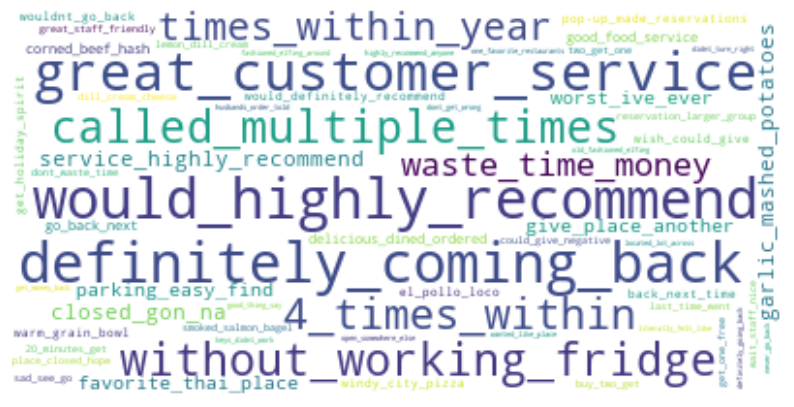

In [62]:

wordcloud = WordCloud(background_color='white').generate_from_frequencies(total_word_frequency_closed)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

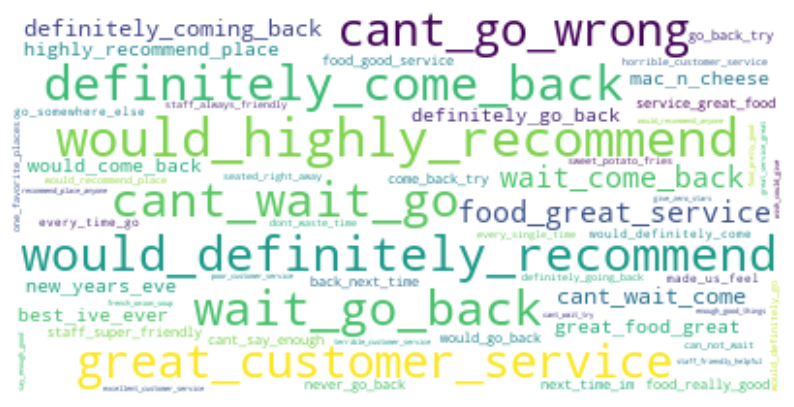

In [63]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(total_word_frequency_open)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()